In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import scipy.io as sio
from scipy import stats
from importlib import reload
from matplotlib import pyplot as plt
import sys
#sys.path.append('/home/jma819/post_cmfe_analysis')
sys.path.append('/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis')
import python_utils_jjm as utils_jjm
import dlc_utils
import caiman
import statsmodels.formula.api as smf
import scipy.spatial.distance as dist
import itertools
import math
import warnings
import numbers
from multiprocessing import Pool
from functools import partial
warnings.filterwarnings(action='once')

/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of 

In [3]:
reload(utils_jjm)
reload(dlc_utils)

<module 'dlc_utils' from '/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis/dlc_utils.py'>

In [4]:
cnmfe_file_key = pd.read_csv('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/cnmfe_file_key.csv')
#cnmfe_file_key = pd.read_csv('/projects/p30771/dlc_analysis/openfield_dlc_output/cnmfe_file_key.csv')

In [5]:
cnmfe_base_dir = '/Volumes/My_Passport/cnmfe_analysis_files/batch_output_files/'
#cnmfe_base_dir = '/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/'
wt_CNMFE_file = ['30-Mar_20_39_05_out.mat', '30-Mar_20_45_16_out.mat', '27-Feb_17_33_59_out.mat', '22-Mar_22_52_02_out.mat',
                 '28-Feb_16_10_05_out.mat', '27-Feb_17_32_15_out.mat', '28-Feb_16_21_21_out.mat', '25-Mar_13_27_27_out.mat',
                 '25-Mar_14_22_02_out.mat', '25-Mar_14_22_44_out.mat', '26-Mar_18_33_55_out.mat', '27-Mar_00_26_12_out.mat', '27-Mar_00_48_46_out.mat']

ko_CNMFE_files = ['31-Mar_13_28_15_out.mat', '29-Mar_21_42_20_out.mat', '13-Apr_17_57_40_out.mat', '29-Mar_14_27_55_out.mat', '13-Apr_16_01_20_out.mat',
                 '13-Apr_16_11_27_out.mat', '29-Mar_13_39_44_out.mat']

In [6]:
tracking_files = ['/Volumes/My_Passport/dlc_analysis/behavcamvideos/open_field_miniscope/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in wt_CNMFE_file] 
#tracking_files = ['/projects/p30771/dlc_analysis/openfield_dlc_output/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in wt_CNMFE_file] 

In [7]:
CNMFE_dir_paths_list = [str(cnmfe_base_dir+fname) for fname in wt_CNMFE_file]
#CNMFE_dir_paths_list

In [8]:
binning_time = 1 # seconds 
body_part_for_tracking = 'tail_base' #
number_of_bins = 50 #
polynomial_degree = 2 #

grouped_raw_data = {}
success = []
failed = []
for CNMFE_file, tracking_file in zip(CNMFE_dir_paths_list, tracking_files):
    #print(CNMFE_file)
    #print(tracking_file)
    try:
        # load cell fluorescence 
        cell_fluorescence = sio.loadmat(CNMFE_file)
        C_timedelta = utils_jjm.create_fluorescence_time_delta(cell_fluorescence['C'])
        C_normalized = C_timedelta.apply(utils_jjm.normalize).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_z_scored = C_timedelta.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_normalized_z_scored = C_normalized.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_normalized)-1)*(1/20), len(C_normalized)), unit='s'), drop=True)
        # create tracking time deltas
        interpolated = utils_jjm.prepare_timedelta_dfs(tracking_file)
        #load spatial components by session
        com_df, spatial_components = utils_jjm.return_spatial_info(CNMFE_file, 0.6)
        cell_contours, for_dims = utils_jjm.create_contour_layouts(spatial_components)
        #C_z_scored_filtered = utils_jjm.filter_out_by_size(C_z_scored, cell_contours, for_dims, 0.6, 100)
        #store results 
        grouped_raw_data[tracking_file.split('/')[-2]] = {'C': C_timedelta, 'C_z_scored': C_z_scored, 'C_normalized': C_normalized, 'C_normalized_z_scored': C_normalized_z_scored, 
                                                          'interpolated' : interpolated, 'com' : com_df, 'spatial_components' : spatial_components, 'cell_contours': cell_contours,  
                                                         'for_dims' : for_dims}
        success.append((tracking_file.split('/')[-2], CNMFE_file.split('/')[-1]))
    except FileNotFoundError:
        failed.append(tracking_file)
    except OSError:
        failed.append(tracking_file)

## spatial clustering

In [9]:
## combine dfs for each session to bin velocity values across dfs
#downsample
new_sampling_interval = .2
V_df = pd.concat([grouped_raw_data[session]['interpolated'].resample(str(new_sampling_interval)+'S').max() 
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))
all_sessions_v_bins = pd.cut(V_df['tail_base'], bins=50)

V_df['velocity_bins'] = all_sessions_v_bins

In [10]:
# compile and filter fluorescence
filtered_for_analysis = {}
for session in list(grouped_raw_data.keys()):
    filtered_for_analysis[session] = utils_jjm.filter_out_by_size(grouped_raw_data[session]['C_normalized_z_scored'], grouped_raw_data[session]['cell_contours'], 
                                                                  grouped_raw_data[session]['for_dims'], 0.6, 100)
C_df = pd.concat([filtered_for_analysis[session].resample(str(new_sampling_interval)+'S').max()
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))


In [11]:
# clustering info per session 
coactivity_dfs = {}
for session in tqdm(list(grouped_raw_data.keys())):
    # get indicies of small cells 
    cells_to_drop = np.array([cell for cell in range(1, len(grouped_raw_data[session]['cell_contours'])+1) if 
                              len(np.array(np.where(grouped_raw_data[session]['for_dims'][cell]>0.6)[0]))<100])
    #compile and filter cell centers of mass
    filtered_centers_of_mass = grouped_raw_data[session]['com'].drop(cells_to_drop, axis =0)
    coactivity_dfs[session] = filtered_centers_of_mass

100%|██████████| 13/13 [00:03<00:00,  4.01it/s]


In [13]:
com_df = pd.concat(coactivity_dfs)

In [17]:
com_df.loc['GRIN026_H16_M35_S34'].to_csv('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/GRIN026_H16_M35_S34_com.csv')

In [23]:
com_df.to_csv('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/wt_com.csv')

In [83]:
# clustering info per session 
coactivity_dfs = {}
for session in tqdm(list(grouped_raw_data.keys())):
    # get indicies of small cells 
    cells_to_drop = np.array([cell for cell in range(1, len(grouped_raw_data[session]['cell_contours'])+1) if 
                              len(np.array(np.where(grouped_raw_data[session]['for_dims'][cell]>0.6)[0]))<100])
    #compile and filter cell centers of mass
    filtered_centers_of_mass = grouped_raw_data[session]['com'].drop(cells_to_drop, axis =0)

    com_distances = utils_jjm.get_pairwise_distance_by_session(filtered_centers_of_mass)

    ##get binned fluorescence and calc Jaccard scores
    #arguments are sample widths to bin and z score threshold
    cells_in_session = C_df.loc[session].dropna(axis=1).drop('msCamFrame', axis=1)
    binned_fluorescence = cells_in_session.apply(utils_jjm.binning_function_uncrop, args=[1, 2])

    reindexed = binned_fluorescence.set_index(int(x) for x in np.linspace(0, len(binned_fluorescence)-1, len(binned_fluorescence)))

    #ks_results_2sided, ks_one_sided_more, ks_one_sided_less, coactivity_dfs = utils_jjm.spatial_coordination_by_session(reindexed, 10, com_distances)
    coactivity_dfs[session] = utils_jjm.spatial_coordination_by_session(reindexed)
    
    



  0%|          | 0/13 [00:00<?, ?it/s]

  8%|▊         | 1/13 [12:32<2:30:31, 752.62s/it]

 15%|█▌        | 2/13 [33:32<2:45:51, 904.71s/it]

 23%|██▎       | 3/13 [1:28:07<4:29:20, 1616.03s/it]

 31%|███       | 4/13 [1:37:02<3:13:43, 1291.52s/it]

 38%|███▊      | 5/13 [3:24:22<6:18:09, 2836.24s/it]

 46%|████▌     | 6/13 [5:56:35<9:11:16, 4725.17s/it]

 54%|█████▍    | 7/13 [8:13:33<9:37:17, 5772.97s/it]

 62%|██████▏   | 8/13 [8:38:31<6:14:13, 4490.64s/it]

 69%|██████▉   | 9/13 [8:53:02<3:46:58, 3404.72s/it]

 77%|███████▋  | 10/13 [9:08:38<2:13:11, 2663.98s/it]

 85%|████████▍ | 11/13 [10:52:23<2:04:24, 3732.25s/it]

 92%|█████████▏| 12/13 [12:06:16<1:05:42, 3942.52s/it]

100%|██████████| 13/13 [13:31:02<00:00, 3743.26s/it]  


In [125]:
#save coactivity info to h5py file
for session in tqdm(list(grouped_raw_data.keys())):
    f = h5py.File("/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis/openfield_analysis/spatial_clustering/" + str(session) +"clustering.h5", "w")

    for time_pt in range(len(coactivity_dfs[session])):
        dset = f.create_dataset(str(time_pt), np.shape(coactivity_dfs[session][time_pt].values), dtype=np.float32)
        dset[:, :] = coactivity_dfs[session][time_pt].values

    cell_pair_ids = f.create_dataset('cell_ids', np.shape(list(coactivity_dfs[session][0].columns)), dtype='i')
    cell_pair_ids[:, :] = list(coactivity_dfs[session][0].columns)

    f.close()



  0%|          | 0/13 [00:00<?, ?it/s]

  8%|▊         | 1/13 [00:06<01:18,  6.53s/it]

 15%|█▌        | 2/13 [00:17<01:25,  7.81s/it]

 23%|██▎       | 3/13 [00:29<01:31,  9.17s/it]

 31%|███       | 4/13 [00:39<01:23,  9.24s/it]

 38%|███▊      | 5/13 [00:59<01:41, 12.71s/it]

 46%|████▌     | 6/13 [01:29<02:05, 17.93s/it]

 54%|█████▍    | 7/13 [01:54<01:58, 19.80s/it]

 62%|██████▏   | 8/13 [02:08<01:31, 18.29s/it]

 69%|██████▉   | 9/13 [02:23<01:08, 17.21s/it]

 77%|███████▋  | 10/13 [02:32<00:43, 14.58s/it]

 85%|████████▍ | 11/13 [02:49<00:31, 15.53s/it]

 92%|█████████▏| 12/13 [03:03<00:15, 15.03s/it]

100%|██████████| 13/13 [03:26<00:00, 15.90s/it]


In [314]:
spatial_coordination_by_session = {}
for session in list(grouped_raw_data.keys()):
    print(session)
    f = h5py.File("/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis/openfield_analysis/spatial_clustering/" + str(session) +"clustering.h5", "r")
# get indicies of small cells 
    cells_to_drop = np.array([cell for cell in range(1, len(grouped_raw_data[session]['cell_contours'])+1) if 
                          len(np.array(np.where(grouped_raw_data[session]['for_dims'][cell]>0.6)[0]))<100])
#compile and filter cell centers of mass
    filtered_centers_of_mass = grouped_raw_data[session]['com'].drop(cells_to_drop, axis =0)
    com_distances = utils_jjm.get_pairwise_distance_by_session(filtered_centers_of_mass)

# get one sided ks tests from h5 data set
    binnums = 10
    ks_one_sided_more = []
    ks_one_sided_less = []
    for time_point in time_points:
        active_cells = [cell_ids[x] for x in [index[0] for index in np.argwhere(f[str(time_points[time_point])][0, 0:len(cell_ids)])]]
        active_cell_distances = [com_distances[cell].values[0] for cell in active_cells]
        cum_results_coactive = stats.cumfreq(active_cell_distances, numbins=binnums, defaultreallimits=(0, 500))
        less_result = stats.kstest(cum_results_coactive.cumcount/len(active_cell_distances), 'norm', alternative='less')
        more_result = stats.kstest(cum_results_coactive.cumcount/len(active_cell_distances), 'norm', alternative='greater')
        ks_one_sided_more.append(more_result)
        ks_one_sided_less.append(less_result)
    
    spatial_coordination_by_session[session] = {'ks_one_sided_more' : ks_one_sided_more, 'ks_one_sided_less' : ks_one_sided_less}

GRIN013_H13_M33_S54


/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


GRIN027_H13_M29_S44
GRIN026_H16_M35_S34


KeyError: (14, 23)

In [318]:
session = list(grouped_raw_data.keys())[2]

In [392]:
f = h5py.File("/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis/openfield_analysis/spatial_clustering/" + str(session) +"clustering.h5", "r")
# get indicies of small cells 
cells_to_drop = np.array([cell for cell in range(1, len(grouped_raw_data[session]['cell_contours'])+1) if 
                          len(np.array(np.where(grouped_raw_data[session]['for_dims'][cell]>0.6)[0]))<100])
#compile and filter cell centers of mass
filtered_centers_of_mass = grouped_raw_data[session]['com'].drop(cells_to_drop, axis =0)
com_distances = utils_jjm.get_pairwise_distance_by_session(filtered_centers_of_mass)

In [348]:
cell_ids = f['cell_ids']

In [397]:
time_point = 95

In [407]:
len(cell_ids)

2775

In [408]:
cell_ids[10]

array([ 1, 13], dtype=int32)

In [411]:
np.argwhere(f[str(time_point)][0, 0:len(cell_ids)])

array([[ 497],
       [ 501],
       [ 516],
       [ 522],
       [ 527],
       [ 533],
       [ 558],
       [ 567],
       [ 582],
       [ 588],
       [ 593],
       [ 599],
       [ 624],
       [ 836],
       [ 842],
       [ 847],
       [ 853],
       [ 878],
       [1652],
       [1657],
       [1663],
       [1688],
       [1918],
       [1924],
       [1949],
       [2114],
       [2139],
       [2334]])

In [421]:
active_cells = [cell_idx[0] for cell_idx in np.argwhere(f[str(time_point)][0, 0:len(cell_ids)])]

In [433]:
len(filtered_centers_of_mass)

75

In [432]:
[cell_ids[cell] for cell in active_cells]

[array([ 9, 10], dtype=int32),
 array([ 9, 14], dtype=int32),
 array([ 9, 30], dtype=int32),
 array([ 9, 36], dtype=int32),
 array([ 9, 42], dtype=int32),
 array([9, 5], dtype=int32),
 array([ 9, 79], dtype=int32),
 array([10, 14], dtype=int32),
 array([10, 30], dtype=int32),
 array([10, 36], dtype=int32),
 array([10, 42], dtype=int32),
 array([10,  5], dtype=int32),
 array([10, 79], dtype=int32),
 array([14, 30], dtype=int32),
 array([14, 36], dtype=int32),
 array([14, 42], dtype=int32),
 array([14,  5], dtype=int32),
 array([14, 79], dtype=int32),
 array([30, 36], dtype=int32),
 array([30, 42], dtype=int32),
 array([30,  5], dtype=int32),
 array([30, 79], dtype=int32),
 array([36, 42], dtype=int32),
 array([36,  5], dtype=int32),
 array([36, 79], dtype=int32),
 array([42,  5], dtype=int32),
 array([42, 79], dtype=int32),
 array([ 5, 79], dtype=int32)]

In [418]:
cell_ids[active_cells[0]][0]

9

In [419]:
cell_ids[active_cells[0]][1]

10

In [435]:
com_distances[5]

,6,7,8,9,10,11,12,13,14,15,...,72,73,74,75,79,81,82,83,84,85
euclidean distance,48.759081,97.739573,86.785313,111.687506,163.764575,182.417924,154.665806,124.42201,117.112269,290.819628,...,136.694692,165.683234,194.307873,392.682322,18.799093,187.925621,93.912756,201.07088,394.654458,396.310159


In [422]:
[com_distances[cell_ids[cell_idx][0]][cell_ids[cell_idx][1]].values[0] for cell_idx in active_cells]

KeyError: 5

In [372]:
for time_pt in range(6251):
    if len(np.argwhere(f[str(time_pt)][0, 0:len(cell_ids)])) > 1:
        print(time_pt)
        break 
    

69


In [369]:
len(f.keys())

6251

,6,7,8,9,10,11,12,13,14,15,...,72,73,74,75,79,81,82,83,84,85
euclidean distance,48.759081,97.739573,86.785313,111.687506,163.764575,182.417924,154.665806,124.42201,117.112269,290.819628,...,136.694692,165.683234,194.307873,392.682322,18.799093,187.925621,93.912756,201.07088,394.654458,396.310159


In [396]:
# get one sided ks tests from h5 data set
binnums = 10
ks_one_sided_more = []
ks_one_sided_less = []
cell_ids = f['cell_ids']
for time_point in time_points:
    print(time_point)
    active_cells = [cell_idx[0] for cell_idx in np.argwhere(f[str(time_point)][0, 0:len(cell_ids)])]
    active_cell_distances = [com_distances[cell_ids[cell_idx][0]][cell_ids[cell_idx][1]].values[0] for cell_idx in active_cells]
    cum_results_coactive = stats.cumfreq(active_cell_distances, numbins=binnums, defaultreallimits=(0, 500))
    less_result = stats.kstest(cum_results_coactive.cumcount/len(active_cell_distances), 'norm', alternative='less')
    more_result = stats.kstest(cum_results_coactive.cumcount/len(active_cell_distances), 'norm', alternative='greater')
    ks_one_sided_more.append(more_result)
    ks_one_sided_less.append(less_result)
    
spatial_coordination_by_session[session] = {'ks_one_sided_more' : ks_one_sided_more, 'ks_one_sided_less' : ks_one_sided_less}

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75


/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


KeyError: 5

In [305]:
coord_index = np.nan_to_num([math.log(result.pvalue, 10)*-1 for result in ks_one_sided_less])

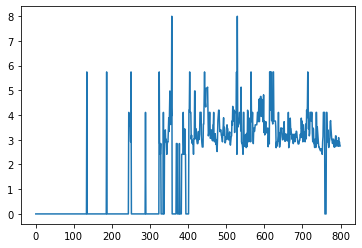

In [311]:
plt.plot(coord_index[1700:2500])
plt.show()

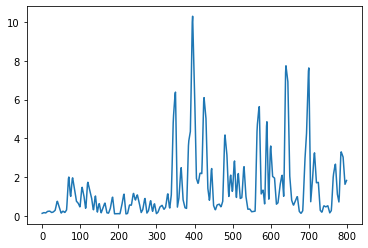

In [310]:
plt.plot(V_df.loc[session]['tail_base'].values[1700:2500])
plt.show()

In [ ]:
## for plotting average spatial coordination during trigger regions

In [ ]:

triggered_activity_across_sessions = {}
for session in list(grouped_raw_data.keys()):
    #inputs activity_threshold, resting_threshold, resting_baseline 
    crossing_indicies = utils_jjm.select_trigger_regions(binned_velocity_df[session], 0.5, 0.5, 20)
    #inputs time_to_plot
    threshold_activity = utils_jjm.average_triggered_regions(V_df.loc[session]['tail_base'].values, crossing_indicies, 40)
    
    f_threshold_activity = utils_jjm.average_triggered_regions(spatial_coordination_activity_in_session 
            , crossing_indicies, 40)
    triggered_activity_across_sessions[session] = pd.concat([threshold_activity, f_threshold_activity], axis=1, keys=['velocity', 'spatial_coordination'])

In [ ]:
#triggered_activity_across_sessions

In [283]:
#concat by mouse 
concacted_by_mouse = {}
for mouse in list(set([session[0:7] for session in list(triggered_activity_across_sessions.keys())])):
    dfs_by_mouse = []
    sessions = []
    for session in list(triggered_activity_across_sessions.keys()):
        if mouse in session:
            if not(triggered_activity_across_sessions[session].empty):
                means = triggered_activity_across_sessions[session].mean(axis=1, level=0)
                dfs_by_mouse.append(means)
                sessions.append(session)
    if len(dfs_by_mouse)>0:
        concacted_by_mouse[mouse] = pd.concat(dfs_by_mouse, axis=1, keys=sessions)
combined_by_mouse = pd.concat(list(concacted_by_mouse.values()), axis=1, keys=list(concacted_by_mouse.keys()))

combined_by_mouse.head()






  0%|          | 0/6250 [00:00<?, ?it/s]/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0





  0%|          | 10/6250 [00:00<01:18, 79.63it/s]




  1%|          | 36/6250 [00:00<01:01, 100.53it/s]




  1%|          | 49/6250 [00:00<01:04, 96.56it/s] 




  1%|          | 59/6250 [00:00<01:21, 7

In [ ]:
binnums = 10
#ks_results_2sided = []
ks_one_sided_more = []
ks_one_sided_less = []
for time_point in tqdm(time_points):
    active_cells = [cell_ids[x] for x in [index[0] for index in np.argwhere(f[str(time_points[time_point])][0, 0:len(cell_ids)])]]
    coactive_cell_distances = [com_distances[cell].values[0] for cell in active_cells]
    #non_coactive_distances = com_distances[coactivity_df[coactivity_df == 0].dropna(axis=1).columns]
    #linear_distribution = np.linspace(1, len(coactive_cell_distances.columns), binnums)
    #binnums=10
    cum_results_coactive = stats.cumfreq(coactive_cell_distances, numbins=binnums, defaultreallimits=(0, 500))
    #cum_results_non_coactive = stats.cumfreq(non_coactive_distances.values[0], numbins=binnums, defaultreallimits=(0, 500))
    #plt.plot(np.linspace(0, 500, binnums), cum_results_coactive.cumcount/len(coactive_cell_distances.values[0]))
    #plt.plot(np.linspace(0, 500, binnums), cum_results_non_coactive.cumcount/len(non_coactive_distances.values[0]))
    #plt.plot(np.linspace(0, 500, binnums), linear_distribution/len(coactive_cell_distances.values[0]))
    #plt.show()
    less_result = stats.kstest(cum_results_coactive.cumcount/len(coactive_cell_distances), 'norm', alternative='less')
    more_result = stats.kstest(cum_results_coactive.cumcount/len(coactive_cell_distances), 'norm', alternative='greater')
    ks_one_sided_more.append(more_result)
    ks_one_sided_less.append(less_result)
    #coordination_index = utils_jjm.create_coordination_index(more_result, less_result)
    #two sided test between coactive and noncoactive distribution 
    #ks_result = stats.ks_2samp(cum_results_coactive.cumcount/len(coactive_cell_distances.values[0]), cum_results_non_coactive.cumcount/len(non_coactive_distances.values[0]))
    #coordination_indicies.append(coordination_index)
    #ks_results_2sided.append(ks_result)
    

In [ ]:
x = np.linspace(-40*.2, 40*.2, 80)
mean=combined_by_mouse.mean(axis=1, level=2)['velocity'].values
plt.plot(x, combined_by_mouse.mean(axis=1, level=2)['velocity'].values, color='k')
std_error = (combined_by_mouse.std(axis=1, level=2)['velocity'])/math.sqrt(combined_by_mouse.mean(axis=1, level=0).shape[1])
plt.fill_between(x, mean-std_error, mean+std_error)
ax = plt.gca()
ax.axvline(x=(0), linestyle='--', color='r')
plt.show()

In [ ]:
x = np.linspace(-40*.2, 40*.2, 80)
mean = combined_by_mouse.mean(axis=1, level=2)['fluorescence'].values
plt.plot(x, mean, color='k')
std_error = (combined_by_mouse.std(axis=1, level=2)['fluorescence'])/math.sqrt(combined_by_mouse.mean(axis=1, level=0).shape[1])
plt.fill_between(x, mean-std_error, mean+std_error)
ax = plt.gca()
ax.axvline(x=0, linestyle='--', color='r')
plt.show()